In [ ]:
# # To unzip
# from zipfile import ZipFile
# file_name = "/content/drive/MyDrive/Colab Notebooks/Melanoma_Skin_Cancer_Detection/dataset.zip"
# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('done')

In [ ]:
# import tensorflow as tf
# tf.test.gpu_device_name()

In [ ]:
# #  Which GPU Am I Using?
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [ ]:
# # Install NVIDIA Drivers
# !nvidia-smi

In [ ]:
# Download Drivers
# https://www.nvidia.com/en-us/drivers/
# Enter your GPU details and download the appropriate drivers.
# Follow the installation instructions for your operating system.

In [ ]:
# Install CUDA Toolkit - Check Compatibility
# https://developer.nvidia.com/cuda-gpus

# Install CUDA
# https://developer.nvidia.com/cuda-downloads

# Verify CUDA Installation: Run
# !nvcc --version

In [ ]:
# Download cuDNN
# https://developer.nvidia.com/cudnn



In [ ]:
# # Install Python Libraries for GPU
# !pip install tensorflow
# !pip install torch torchvision torchaudio 
# --index-url https://download.pytorch.org/whl/cuXX

In [ ]:
# import tensorflow as tf
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


In [ ]:
# import torch

# print("Is CUDA available:", torch.cuda.is_available())
# print("GPU Device Name:", torch.cuda.get_device_name(0))


# Split dataset to Train, Validate and Test

In [ ]:
# !pip install split-folders

import splitfolders
import os

# data_path = os.path.join('..', 'artifacts', 'dataset', 'raw', 'train')
data_path = os.path.join('..', 'artifacts', 'dataset', 'processed', 'train')

splitfolders.ratio(data_path, 
                   'data',
                   seed = 41,
                   ratio = (0.6, 0.25, 0.15)) # train/val/test

# Start to Training

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNet, ResNet50, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Function to create a model with a given base model
def create_transfer_learning_model(base_model, num_classes):
    base_model.trainable = False  # Freeze base model layers
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Function to train a specific model
def train_model(model, train_generator, val_generator, epochs=10, learning_rate=0.0001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy' if train_generator.num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        steps_per_epoch=32)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    accuracy_image_path = 'accuracy_plot.png'
    plt.plot(epochs, acc, label='training accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training validation Accuracy')
    plt.savefig(accuracy_image_path, bbox_inches='tight')
    plt.show()

    loss_image_path = 'loss_plot.png'
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training validation Loss')
    plt.savefig(loss_image_path, bbox_inches='tight')
    plt.show()

    return model, history

# Functions to create specific models
def create_vgg16_model(num_classes):
    return create_transfer_learning_model(VGG16(weights='imagenet', include_top=False), num_classes)

def create_mobilenet_model(num_classes):
    return create_transfer_learning_model(MobileNet(weights='imagenet', include_top=False), num_classes)

def create_resnet50_model(num_classes):
    return create_transfer_learning_model(ResNet50(weights='imagenet', include_top=False), num_classes)

def create_densenet_model(num_classes):
    return create_transfer_learning_model(DenseNet121(weights='imagenet', include_top=False), num_classes)

def create_inceptionv3_model(num_classes):
    return create_transfer_learning_model(InceptionV3(weights='imagenet', include_top=False), num_classes)

# Function to save the model
def save_model(model, filepath):
    model.save(filepath)
    print(f"Model saved to {filepath}")

# Function to load the model
def load_model(filepath):
    model = tf.keras.models.load_model(filepath)
    print(f"Model loaded from {filepath}")
    return model

# Function to evaluate the model
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)

    predicted_classes = np.argmax(predictions, axis=1) if test_generator.num_classes > 1 else (predictions > 0.5).astype(int)

    # Handle binary and multiclass cases
    # if test_generator.num_classes > 1:  # Multiclass classification
    #     predicted_classes = np.argmax(predictions, axis=1)
    # else:  # Binary classification
    #     predicted_classes = (predictions > 0.5).astype(int).flatten()

    true_classes = test_generator.classes
    # class_indices = test_generator.class_indices

    # Metrics
    acc = accuracy_score(true_classes, predicted_classes)
    loss = 1 - acc
    cm = confusion_matrix(true_classes, predicted_classes)
    cr = classification_report(true_classes, predicted_classes)
    kappa = cohen_kappa_score(true_classes, predicted_classes)

    print(f"Accuracy: {acc}")
    print(f"Loss: {loss}")
    print(f"Cohen Kappa Score: {kappa}")
    print("Classification Report:")
    print(cr)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    return acc, kappa, cm, cr

# Function to prepare data generators
def prepare_data_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255)
    train_generator = datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
    val_generator = datagen.flow_from_directory(val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
    test_generator = datagen.flow_from_directory(test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
    return train_generator, val_generator, test_generator


# VGG16

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.5261 - loss: 0.7371 - val_accuracy: 0.5423 - val_loss: 0.6863
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.5804 - loss: 0.6751 - val_accuracy: 0.6302 - val_loss: 0.6398
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - accuracy: 0.6806 - loss: 0.6159 - val_accuracy: 0.7389 - val_loss: 0.6016
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.6975 - loss: 0.5905 - val_accuracy: 0.7601 - val_loss: 0.5668
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.8056 - loss: 0.5504 - val_accuracy: 0.7643 - val_loss: 0.5383
Epoch 6/100
21/32 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7898 - loss: 0.5336

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


32/32 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.7930 - loss: 0.5337 - val_accuracy: 0.7930 - val_loss: 0.5228
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.8087 - loss: 0.5148 - val_accuracy: 0.8038 - val_loss: 0.4982
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - accuracy: 0.8245 - loss: 0.4823 - val_accuracy: 0.8188 - val_loss: 0.4771
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.8627 - loss: 0.4544 - val_accuracy: 0.8238 - val_loss: 0.4581
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.8236 - loss: 0.4676 - val_accuracy: 0.8297 - val_loss: 0.4426
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.8378 - loss: 0.4318 - val_accuracy: 0.8313 - val_loss: 0.4313
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.8261 - loss: 0.4323 - val_accuracy: 0.8330 - val_loss: 0.4212
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.8780 - loss: 0.3948 - val_accuracy: 0.8405 - v

32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.8712 - loss: 0.3089 - val_accuracy: 0.8709 - val_loss: 0.2953
Epoch 57/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.8710 - loss: 0.3182 - val_accuracy: 0.8738 - val_loss: 0.2931
Epoch 58/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.8713 - loss: 0.2850 - val_accuracy: 0.8696 - val_loss: 0.2952
Epoch 59/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.8945 - loss: 0.2761 - val_accuracy: 0.8734 - val_loss: 0.2927
Epoch 60/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8506 - loss: 0.3163 - val_accuracy: 0.8701 - val_loss: 0.2982
Epoch 61/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.8562 - loss: 0.3220 - val_accuracy: 0.8767 - val_loss: 0.2912
Epoch 62/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.8904 - loss: 0.2694 - val_accuracy: 0.8751 - val_loss: 0.2912
Epoch 63/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.9122 - loss: 0.2436 - val_accuracy: 0.8755 

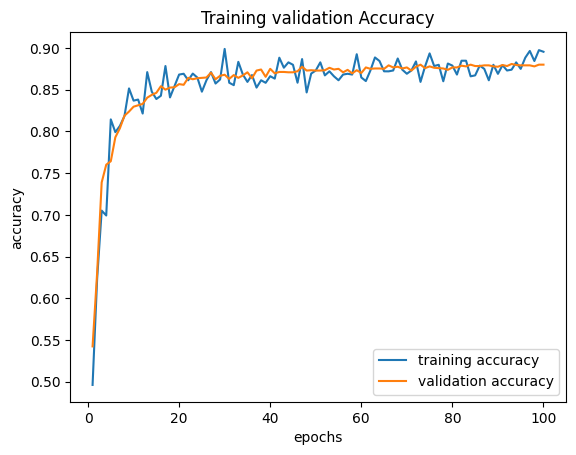

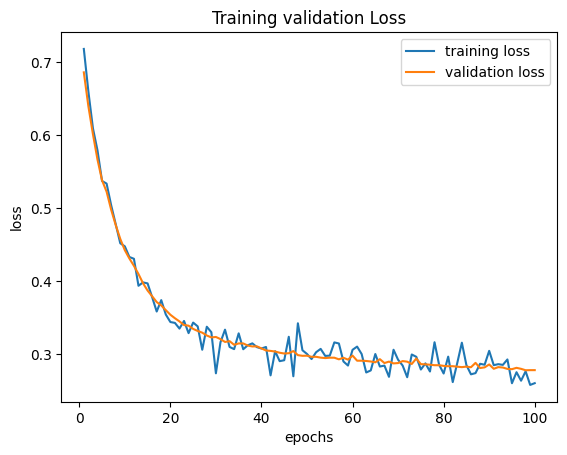

Model saved to vgg16_model.h5
Model loaded from vgg16_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step
Accuracy: 0.8764746703678001
Loss: 0.12352532963219987
Cohen Kappa Score: 0.753068615690903
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       750
           1       0.85      0.90      0.87       691

    accuracy                           0.88      1441
   macro avg       0.88      0.88      0.88      1441
weighted avg       0.88      0.88      0.88      1441



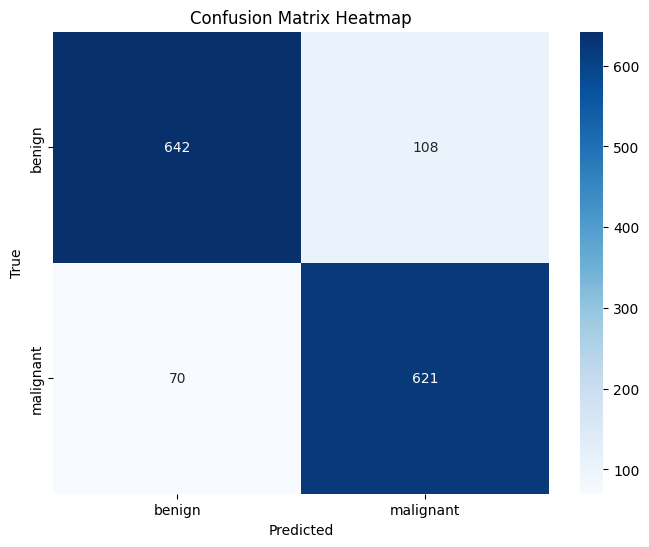

In [3]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    vgg16_model = create_vgg16_model(num_classes)
    trained_vgg16, _ = train_model(vgg16_model, train_gen, val_gen, epochs=100)
    save_model(trained_vgg16, "vgg16_model.h5")
    # save_model(trained_vgg16, "vgg16_model.keras")

    # Load and evaluate VGG16 model
    loaded_vgg16 = load_model("vgg16_model.h5")
    evaluate_model(loaded_vgg16, test_gen)

# Mobilenet

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.


C:\Users\SURESH RAJPUROHIT\AppData\Local\Temp\ipykernel_19824\2760422077.py:59: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  return create_transfer_learning_model(MobileNet(weights='imagenet', include_top=False), num_classes)


Epoch 1/100


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.5814 - loss: 0.7438 - val_accuracy: 0.7647 - val_loss: 0.4864
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 583ms/step - accuracy: 0.7644 - loss: 0.4606 - val_accuracy: 0.8342 - val_loss: 0.3991
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 580ms/step - accuracy: 0.8629 - loss: 0.3622 - val_accuracy: 0.8384 - val_loss: 0.3655
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 580ms/step - accuracy: 0.8556 - loss: 0.3186 - val_accuracy: 0.8434 - val_loss: 0.3580
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 580ms/step - accuracy: 0.8565 - loss: 0.3435 - val_accuracy: 0.8646 - val_loss: 0.3297
Epoch 6/100
21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8863 - loss: 0.3086

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 520ms/step - accuracy: 0.8809 - loss: 0.3155 - val_accuracy: 0.8630 - val_loss: 0.3211
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 575ms/step - accuracy: 0.8787 - loss: 0.3122 - val_accuracy: 0.8688 - val_loss: 0.3148
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 579ms/step - accuracy: 0.8682 - loss: 0.3097 - val_accuracy: 0.8646 - val_loss: 0.3139
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 584ms/step - accuracy: 0.9029 - loss: 0.2603 - val_accuracy: 0.8713 - val_loss: 0.3016
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 591ms/step - accuracy: 0.8884 - loss: 0.2579 - val_accuracy: 0.8776 - val_loss: 0.2978
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 595ms/step - accuracy: 0.8806 - loss: 0.2559 - val_accuracy: 0.8721 - val_loss: 0.2972
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 526ms/step - accuracy: 0.8925 - loss: 0.2705 - val_accuracy: 0.8825 - val_loss: 0.2992
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 583ms/step - accuracy: 0.8768 - loss: 0.2825 - val_accu

Epoch 56/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 575ms/step - accuracy: 0.9302 - loss: 0.1865 - val_accuracy: 0.8917 - val_loss: 0.2733
Epoch 57/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 571ms/step - accuracy: 0.9371 - loss: 0.1717 - val_accuracy: 0.8942 - val_loss: 0.2678
Epoch 58/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 574ms/step - accuracy: 0.9256 - loss: 0.2001 - val_accuracy: 0.8950 - val_loss: 0.2620
Epoch 59/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 567ms/step - accuracy: 0.9322 - loss: 0.1872 - val_accuracy: 0.8900 - val_loss: 0.2690
Epoch 60/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 513ms/step - accuracy: 0.9369 - loss: 0.1775 - val_accuracy: 0.8946 - val_loss: 0.2603
Epoch 61/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 568ms/step - accuracy: 0.9308 - loss: 0.1818 - val_accuracy: 0.8955 - val_loss: 0.2666
Epoch 62/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 572ms/step - accuracy: 0.9247 - loss: 0.2097 - val_accuracy: 0.8913 - val_loss: 0.2685
Epoch 63/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 574ms/step - accuracy: 0.9227 - loss: 0

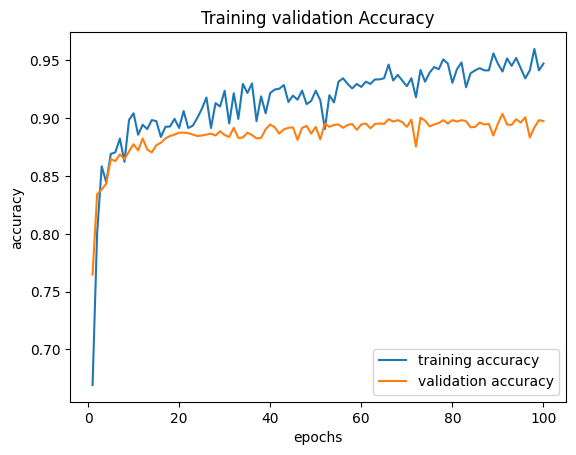

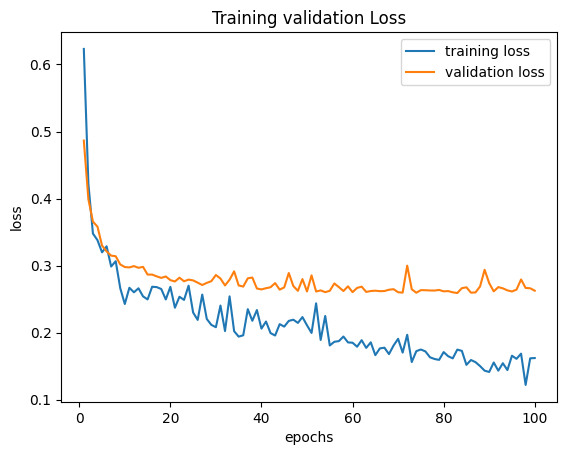

Model saved to mobilenet_model.h5


Model loaded from mobilenet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step
Accuracy: 0.8931297709923665
Loss: 0.10687022900763354
Cohen Kappa Score: 0.7860467717179196
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       750
           1       0.88      0.90      0.89       691

    accuracy                           0.89      1441
   macro avg       0.89      0.89      0.89      1441
weighted avg       0.89      0.89      0.89      1441



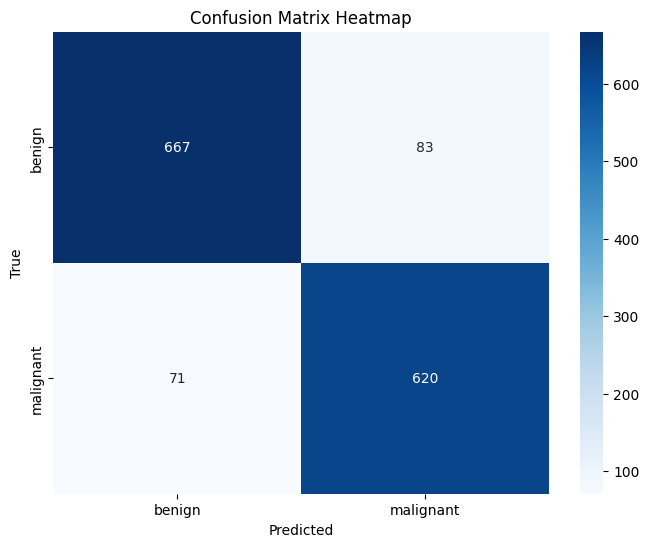

In [12]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"


    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    mobilenet_model = create_mobilenet_model(num_classes)
    trained_mobilenet, _ = train_model(mobilenet_model, train_gen, val_gen, epochs=100)
    save_model(trained_mobilenet, "mobilenet_model.h5")

    # Load and evaluate VGG16 model
    loaded_mobilenet = load_model("mobilenet_model.h5")
    evaluate_model(loaded_mobilenet, test_gen)

# Resnet50

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5607 - loss: 0.6953 - val_accuracy: 0.7509 - val_loss: 0.6479
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6856 - loss: 0.6330 - val_accuracy: 0.7501 - val_loss: 0.6110
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7234 - loss: 0.6056 - val_accuracy: 0.7539 - val_loss: 0.5847
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7165 - loss: 0.5783 - val_accuracy: 0.7630 - val_loss: 0.5645
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7728 - loss: 0.5597 - val_accuracy: 0.7455 - val_loss: 0.5529
Epoch 6/100
21/32 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 0.7238 - loss: 0.5653

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7267 - loss: 0.5620 - val_accuracy: 0.7572 - val_loss: 0.5412
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7466 - loss: 0.5398 - val_accuracy: 0.7526 - val_loss: 0.5316
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7832 - loss: 0.4975 - val_accuracy: 0.7493 - val_loss: 0.5231
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7569 - loss: 0.5103 - val_accuracy: 0.7393 - val_loss: 0.5214
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7642 - loss: 0.4975 - val_accuracy: 0.7580 - val_loss: 0.5046
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7447 - loss: 0.5026 - val_accuracy: 0.7497 - val_loss: 0.5054
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8029 - loss: 0.4743 - val_accuracy: 0.7680 - val_loss: 0.4921
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7826 - loss: 0.4733 - val_accuracy: 0.7514 - val_loss:

32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8100 - loss: 0.4230 - val_accuracy: 0.7901 - val_loss: 0.4411
Epoch 57/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7979 - loss: 0.4065 - val_accuracy: 0.7788 - val_loss: 0.4303
Epoch 58/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7968 - loss: 0.4253 - val_accuracy: 0.7926 - val_loss: 0.4381
Epoch 59/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8172 - loss: 0.4044 - val_accuracy: 0.7793 - val_loss: 0.4297
Epoch 60/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8022 - loss: 0.3921 - val_accuracy: 0.7905 - val_loss: 0.4356
Epoch 61/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7867 - loss: 0.4393 - val_accuracy: 0.7784 - val_loss: 0.4287
Epoch 62/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8108 - loss: 0.4020 - val_accuracy: 0.7768 - val_loss: 0.4306
Epoch 63/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7819 - loss: 0.4343 - val_accuracy: 0.7851 - val_lo

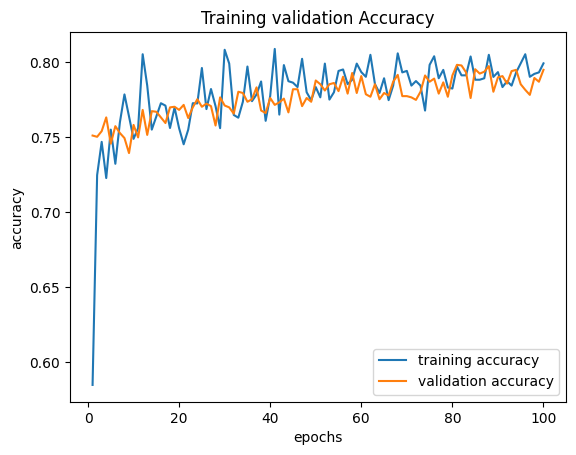

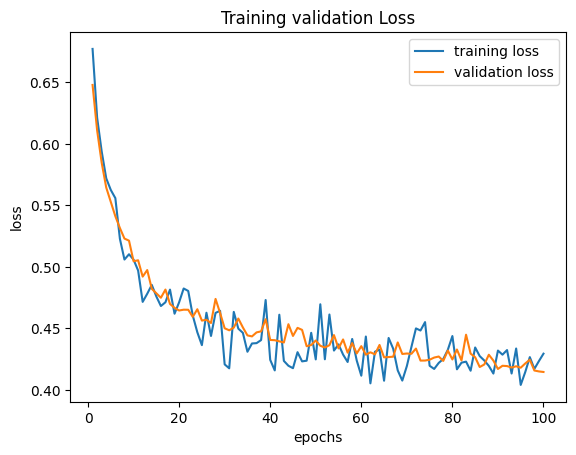

Model saved to resnet50_model.h5


Model loaded from resnet50_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 555ms/step
Accuracy: 0.7994448299791811
Loss: 0.2005551700208189
Cohen Kappa Score: 0.6006032444770523
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       750
           1       0.75      0.87      0.81       691

    accuracy                           0.80      1441
   macro avg       0.80      0.80      0.80      1441
weighted avg       0.81      0.80      0.80      1441



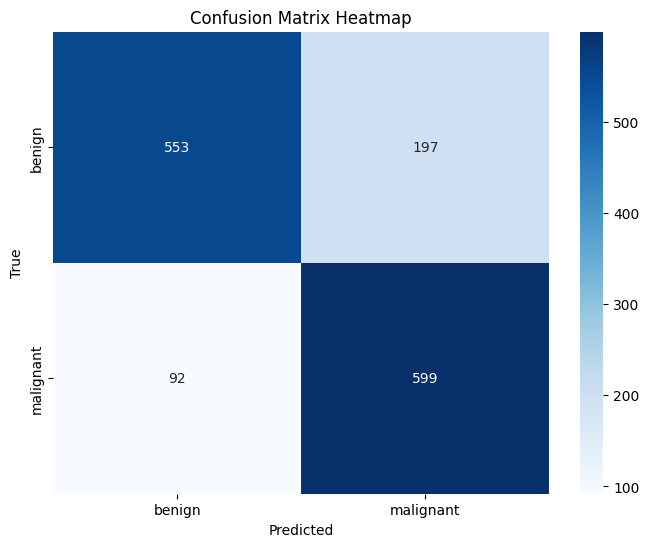

In [8]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    resnet50_model = create_resnet50_model(num_classes)
    trained_resnet50, _ = train_model(resnet50_model, train_gen, val_gen, epochs=100)
    save_model(trained_resnet50, "resnet50_model.h5")

    # Load and evaluate VGG16 model
    loaded_resnet50 = load_model("resnet50_model.h5")
    evaluate_model(loaded_resnet50, test_gen)

# Densenet

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
Epoch 1/100


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4335 - loss: 0.8259 - val_accuracy: 0.7284 - val_loss: 0.5576
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7445 - loss: 0.5276 - val_accuracy: 0.8176 - val_loss: 0.4302
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8315 - loss: 0.4050 - val_accuracy: 0.8417 - val_loss: 0.3734
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8637 - loss: 0.3531 - val_accuracy: 0.8513 - val_loss: 0.3454
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8747 - loss: 0.3080 - val_accuracy: 0.8609 - val_loss: 0.3273
Epoch 6/100
21/32 ━━━━━━━━━━━━━━━━━━━━ 6s 603ms/step - accuracy: 0.8483 - loss: 0.3300

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8518 - loss: 0.3287 - val_accuracy: 0.8659 - val_loss: 0.3168
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8589 - loss: 0.3211 - val_accuracy: 0.8634 - val_loss: 0.3136
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8826 - loss: 0.2929 - val_accuracy: 0.8659 - val_loss: 0.3027
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8877 - loss: 0.2711 - val_accuracy: 0.8701 - val_loss: 0.2948
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8649 - loss: 0.3013 - val_accuracy: 0.8796 - val_loss: 0.2957
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8929 - loss: 0.2860 - val_accuracy: 0.8788 - val_loss: 0.2824
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9118 - loss: 0.2290 - val_accuracy: 0.8834 - val_loss: 0.2801
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8753 - loss: 0.2835 - val_accuracy: 0.8751 - val_loss:

32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9093 - loss: 0.2322 - val_accuracy: 0.8996 - val_loss: 0.2427
Epoch 57/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9008 - loss: 0.2431 - val_accuracy: 0.8984 - val_loss: 0.2378
Epoch 58/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9072 - loss: 0.2298 - val_accuracy: 0.8996 - val_loss: 0.2366
Epoch 59/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9188 - loss: 0.2128 - val_accuracy: 0.8988 - val_loss: 0.2384
Epoch 60/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9097 - loss: 0.2136 - val_accuracy: 0.8980 - val_loss: 0.2356
Epoch 61/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9068 - loss: 0.2246 - val_accuracy: 0.9005 - val_loss: 0.2340
Epoch 62/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8902 - loss: 0.2382 - val_accuracy: 0.8992 - val_loss: 0.2332
Epoch 63/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9199 - loss: 0.2052 - val_accuracy: 0.8992 - val_lo

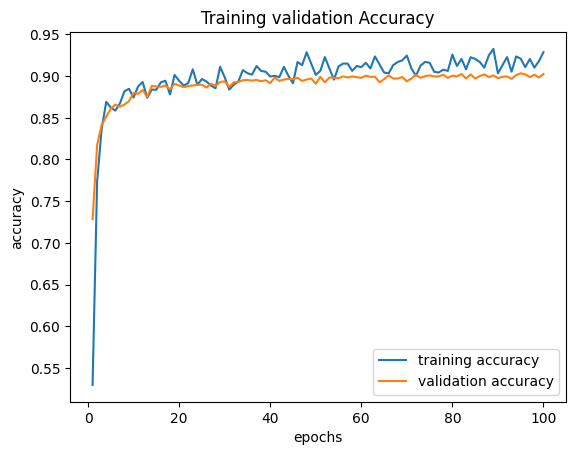

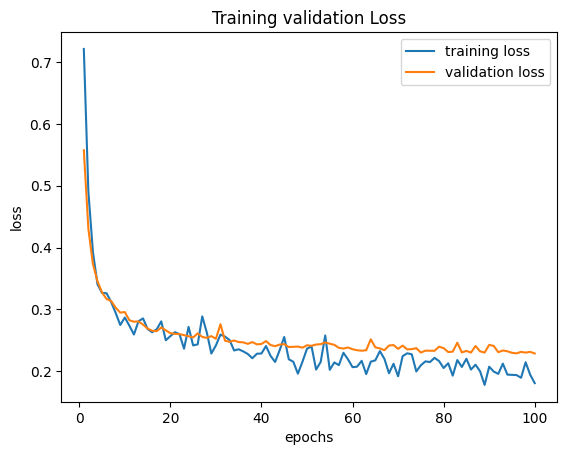

Model saved to densenet_model.h5


Model loaded from densenet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 654ms/step
Accuracy: 0.9097848716169327
Loss: 0.09021512838306733
Cohen Kappa Score: 0.8192256027421584
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       750
           1       0.91      0.90      0.91       691

    accuracy                           0.91      1441
   macro avg       0.91      0.91      0.91      1441
weighted avg       0.91      0.91      0.91      1441



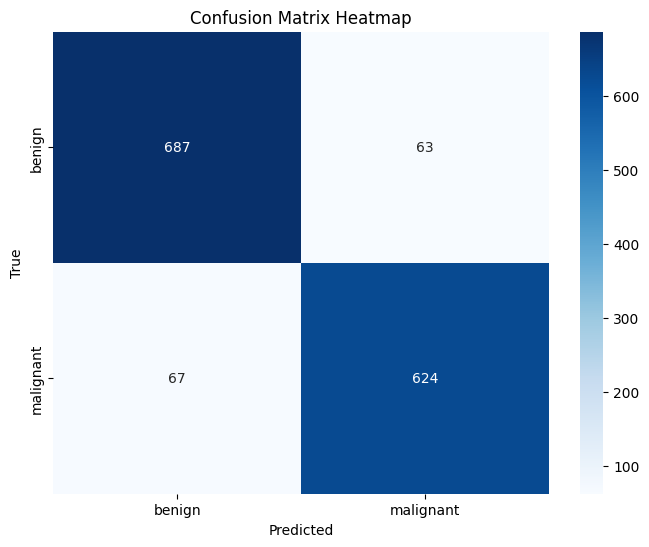

In [9]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    densenet_model = create_densenet_model(num_classes)
    trained_densenet, _ = train_model(densenet_model, train_gen, val_gen, epochs=100)
    save_model(trained_densenet, "densenet_model.h5")

    # Load and evaluate VGG16 model
    loaded_densenet = load_model("densenet_model.h5")
    evaluate_model(loaded_densenet, test_gen)

# Inceptionv3

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
Epoch 1/100


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7031 - loss: 0.5854 - val_accuracy: 0.8138 - val_loss: 0.4064
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8403 - loss: 0.3776 - val_accuracy: 0.8467 - val_loss: 0.3560
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8524 - loss: 0.3365 - val_accuracy: 0.8471 - val_loss: 0.3468
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8791 - loss: 0.2793 - val_accuracy: 0.8546 - val_loss: 0.3351
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8511 - loss: 0.3582 - val_accuracy: 0.8688 - val_loss: 0.3135
Epoch 6/100
21/32 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.8579 - loss: 0.3035

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 965ms/step - accuracy: 0.8592 - loss: 0.3052 - val_accuracy: 0.8684 - val_loss: 0.3101
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8810 - loss: 0.2824 - val_accuracy: 0.8671 - val_loss: 0.3149
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8585 - loss: 0.3011 - val_accuracy: 0.8713 - val_loss: 0.3019
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8873 - loss: 0.2849 - val_accuracy: 0.8692 - val_loss: 0.3059
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8909 - loss: 0.2654 - val_accuracy: 0.8709 - val_loss: 0.3023
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9012 - loss: 0.2198 - val_accuracy: 0.8592 - val_loss: 0.3267
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 950ms/step - accuracy: 0.8967 - loss: 0.2472 - val_accuracy: 0.8680 - val_loss: 0.3135
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8853 - loss: 0.2551 - val_accuracy: 0.8713 - val

32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9242 - loss: 0.1775 - val_accuracy: 0.8830 - val_loss: 0.2898
Epoch 57/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9275 - loss: 0.1803 - val_accuracy: 0.8838 - val_loss: 0.2859
Epoch 58/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9263 - loss: 0.1782 - val_accuracy: 0.8859 - val_loss: 0.2825
Epoch 59/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9336 - loss: 0.1654 - val_accuracy: 0.8838 - val_loss: 0.2795
Epoch 60/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 934ms/step - accuracy: 0.9433 - loss: 0.1550 - val_accuracy: 0.8809 - val_loss: 0.2826
Epoch 61/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9369 - loss: 0.1705 - val_accuracy: 0.8796 - val_loss: 0.2953
Epoch 62/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9492 - loss: 0.1579 - val_accuracy: 0.8809 - val_loss: 0.2838
Epoch 63/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9130 - loss: 0.1948 - val_accuracy: 0.8855 - val

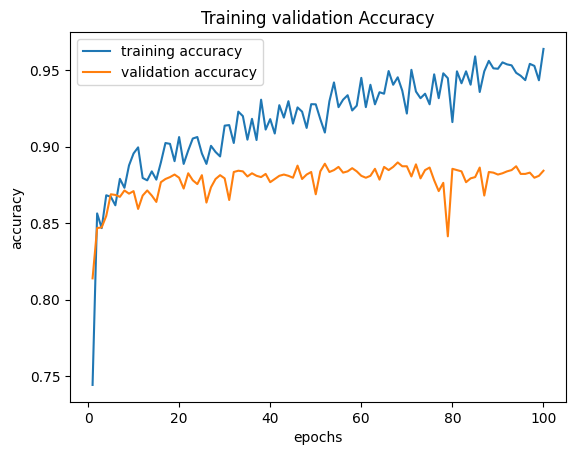

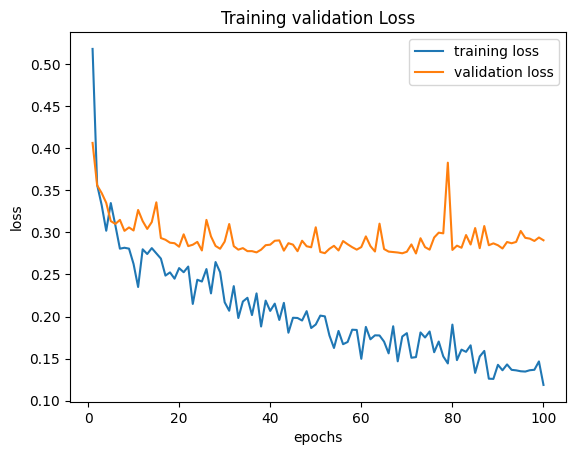

Model saved to inceptionv3_model.h5


Model loaded from inceptionv3_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step
Accuracy: 0.8848022206800833
Loss: 0.1151977793199167
Cohen Kappa Score: 0.7692963522347409
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       750
           1       0.88      0.88      0.88       691

    accuracy                           0.88      1441
   macro avg       0.88      0.88      0.88      1441
weighted avg       0.88      0.88      0.88      1441



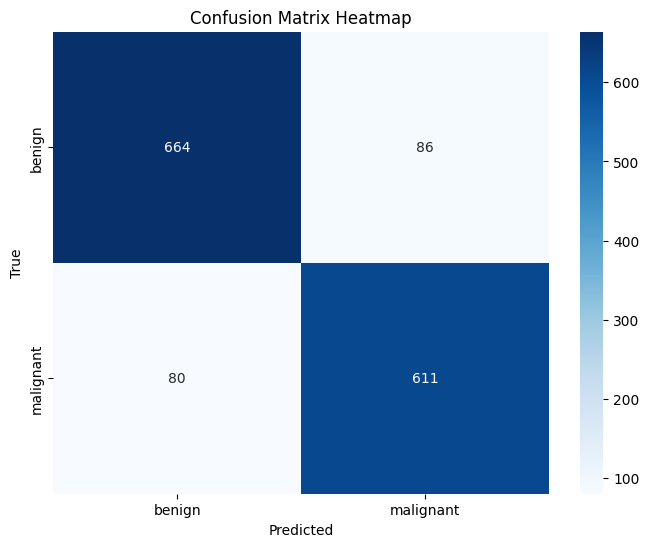

In [11]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    inceptionv3_model = create_inceptionv3_model(num_classes)
    trained_inceptionv3, _ = train_model(inceptionv3_model, train_gen, val_gen, epochs=100)
    save_model(trained_inceptionv3, "inceptionv3_model.h5")

    # Load and evaluate VGG16 model
    loaded_inceptionv3 = load_model("inceptionv3_model.h5")
    evaluate_model(loaded_inceptionv3, test_gen)

# Deployment

In [13]:
!pip install tensorflow opencv-python-headless streamlit numpy pillow


In [ ]:
%%writefile app.py
import streamlit as st
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from PIL import Image

# Function to preprocess the image (including the inverse_masked_area)
def preprocess_image(image_path):
    """
    Preprocess the image and return the inverse masked area.

    Parameters:
        image_path (str): Path to the input image.

    Returns:
        inverse_masked_image (ndarray): Image with inverse masked area.
        processing_stages_path (str): Path to saved 'processing_stages.png'.
    """
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert to 256x256 grayscale
    gray_image = cv2.cvtColor(cv2.resize(image, (256, 256)), cv2.COLOR_BGR2GRAY)

    # Apply BM3D filtering
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 10, 7, 21)

    # Apply binary thresholding
    _, binary_mask = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Perform morphological operations
    kernel = np.ones((5, 5), np.uint8)
    morphed_image = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Extract the masked area
    masked_area = cv2.bitwise_and(gray_image, gray_image, mask=morphed_image)

    # Extract the inverse of the masked area
    inverse_mask = cv2.bitwise_not(morphed_image)
    inverse_masked_area = cv2.bitwise_and(gray_image, gray_image, mask=inverse_mask)

    # Save all stages for visualization
    processing_stages_path = "processing_stages.png"
    stages = np.hstack((gray_image, morphed_image, masked_area, inverse_masked_area))
    cv2.imwrite(processing_stages_path, stages)

    return inverse_masked_area, processing_stages_path

# Prediction function using VGG16
def predict(image, model):
    """
    Predict using a pre-trained VGG16 model.

    Parameters:
        image (ndarray): Preprocessed image (inverse masked area).
        model (keras.Model): Pre-trained VGG16 model.

    Returns:
        str: Prediction result (e.g., 'Benign' or 'Malignant').
    """
    # Resize the image to match VGG16 input size (224x224)
    image_resized = cv2.resize(image, (224, 224))

    # Convert to 3-channel image (VGG16 expects RGB input)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

    # Convert to array and preprocess for VGG16
    image_array = img_to_array(image_rgb)
    image_array = np.expand_dims(image_array, axis=0)
    image_preprocessed = preprocess_input(image_array)

    # Predict using the model
    predictions = model.predict(image_preprocessed)

    # Assume binary classification: class 0 = 'Benign', class 1 = 'Malignant'
    predicted_class = np.argmax(predictions, axis=1)[0]
    return "Malignant" if predicted_class == 1 else "Benign"

# Streamlit app
def main():
    st.title("Melanoma Skin Cancer Detection")
    st.write("Upload an image to detect melanoma skin cancer.")

    # Input image folder
    input_folder = "uploaded_images"
    if not os.path.exists(input_folder):
        os.makedirs(input_folder)

    # Load pre-trained VGG16 model
    # base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # # Add custom classification layers
    # x = base_model.output
    # x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(256, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # predictions = tf.keras.layers.Dense(2, activation='softmax')(x)
    # vgg16_model = Model(inputs=base_model.input, outputs=predictions)
    # vgg16_model.load_weights("/content/processed_resnet50_model.h5")  # Load custom-trained weights

    vgg16_model = load_model(r'/content/processed_resnet50_model.h5')

    # File uploader
    uploaded_file = st.file_uploader("Choose an image", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Save the uploaded image
        image_path = os.path.join(input_folder, uploaded_file.name)
        with open(image_path, "wb") as f:
            f.write(uploaded_file.getbuffer())
        st.success(f"Image saved at {image_path}")

        # Display the uploaded image
        st.image(image_path, caption="Uploaded Image", use_column_width=True)

        # Preprocess the image
        st.write("Processing the image...")
        inverse_masked_image, processing_stages_path = preprocess_image(image_path)

        # Show processing stages
        st.write("Processing stages:")
        st.image(processing_stages_path, caption="Processing Stages", use_column_width=True)

        # Perform prediction
        st.write("Predicting...")
        result = predict(inverse_masked_image, vgg16_model)

        # Display the prediction result
        st.write(f"**Prediction Result:** {result}")

# Run the app
if __name__ == "__main__":
    main()


In [ ]:
!npm install localtunnel

 35.197.82.8

In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# !streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501
# !streamlit run app.py --server.address=localhost &>/content/logs.txt & npx localtunnel --port 8501
!streamlit run app.py & npx localtunnel --port 8501

# !pip install pyngrok
# from pyngrok import ngrok
# public_url = ngrok.connect(port='8501')
# print(public_url)
# !streamlit run app.py